# Spot Price Forecasting

In [1]:
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

import datetime
import pandas as pd
import numpy as np
import cvxpy as cp
from matplotlib import pyplot as plt

from utils import *
golden_mean = (np.sqrt(5) - 1.0) / 2.0  # Aesthetic ratio

## Train and test data sets

(<AxesSubplot: >, <AxesSubplot: >)

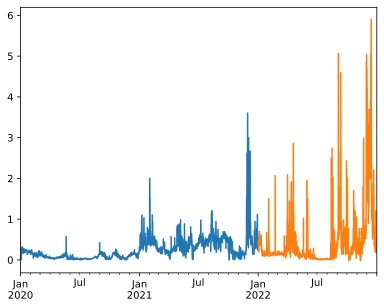

In [2]:
# Read data from CSV files and create a pandas series
df = pd.read_csv("data/spot_price_data.csv", index_col=0)
df.index = pd.to_datetime(df.index, format='%Y-%m-%d %H:%M:%S')
spot_price_data = df["Spot Price (NOK/kWh)"]

spot_price_data.to_pickle("data/spot_price_data.pickle")

# Split data into train set and test set
train = spot_price_data[spot_price_data.index.year <= 2021]
test = spot_price_data[spot_price_data.index.year > 2021]

train.plot(), test.plot()

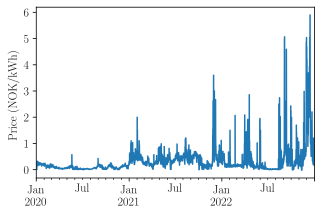

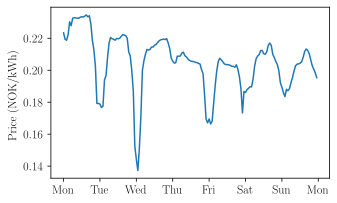

In [7]:
def customize_monthly_x_axis(ax, interval):
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=interval))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.xticks(rotation=45)

def customize_weekly_x_axis(ax, start_date):
    end_date = start_date + pd.DateOffset(days=7)
    dates = pd.date_range(start_date, end_date, freq='D')
    day_labels = [date.strftime('%a') for date in dates]

    major_tick_positions = dates

    ax.set_xticks(major_tick_positions)
    ax.set_xticklabels(day_labels)

    ax.tick_params(axis='x', which='minor', length=0)

# Plot load data (2020-2022)
latexify(fig_width=5)
fig, ax = plt.subplots()
spot_price_data.plot(ax=ax, color="tab:blue")
plt.ylabel("Price (NOK/kWh)")
# customize_monthly_x_axis(ax, interval=3)

# plt.savefig("figures/spot_prices_2020-2022.pdf")
    
# Plot load data (1 week)
latexify(fig_width=5)
fig, ax = plt.subplots()
week_data = spot_price_data.loc['2020-01-20':'2020-01-26']
plt.plot(week_data.index, week_data.values, color="tab:blue")
plt.ylabel("Price (NOK/kWh)")
customize_weekly_x_axis(ax, week_data.index[0])

# plt.savefig("figures/spot_prices_one_week.pdf")

## Seasonal baseline forecast

In [8]:
PERIODS = [period / harmonic for harmonic in [1, 2, 3, 4] for period in [24, 24*7, 24*365]]
PERIODS = [3600 * period for period in PERIODS]

def featurize_for_baseline(data, periods):
    seconds = data.index.astype(np.int64) / 1E9
    X = np.zeros((len(seconds), 1 + 2 * len(periods)))
    trig_functions = [np.sin, np.cos]

    for idx, (period, trig) in enumerate([(p, t) for p in periods for t in trig_functions]):
        X[:, idx] = trig(2 * np.pi * seconds / period)

    X[:, -1] = np.ones(len(seconds))
    y = data.values
    return X, y

# Featurize train and test data
Xtr, ytr = featurize_for_baseline(train, PERIODS)
Xte, yte = featurize_for_baseline(test, PERIODS)

def fit_seasonal_baseline(X, y, reg_weight=0.001):
    params = cp.Variable(X.shape[1])
    objective = cp.Minimize(cp.sum_squares(X @ params - y) + reg_weight * cp.sum_squares(params))
    problem = cp.Problem(objective)
    problem.solve()
    return params.value

# Fit seasonal baseline to train data
baseline_params = fit_seasonal_baseline(Xtr, ytr)

def predict_with_baseline(X, parameters):
    return X @ parameters

# Make predictions and calculate RMSE
train_baseline = predict_with_baseline(Xtr, baseline_params)
test_baseline = predict_with_baseline(Xte, baseline_params)
def RMSE(array):
    return np.sqrt(np.mean(array**2))
train_rmse = RMSE(train.values - train_baseline)
test_rmse = RMSE(test.values - test_baseline)

print('Baseline train RMSE', train_rmse)
print('Baseline test RMSE', test_rmse)

# Create prediction Series
train_baseline_series = pd.Series(index=train.index, data=train_baseline)
test_baseline_series = pd.Series(index=test.index, data=test_baseline)
baseline = pd.concat([train_baseline_series, test_baseline_series])


# Extend baseline to 2023
date_range_2023 = pd.date_range(start='2023-01-01 00:00:00', end='2023-12-31 23:00:00', freq='H')
dummy_series_2023 = pd.Series(index=date_range_2023, dtype='float64')
X_2023, _ = featurize_for_baseline(dummy_series_2023, PERIODS)
baseline_2023 = predict_with_baseline(X_2023, baseline_params)
baseline_2023_series = pd.Series(index=date_range_2023, data=baseline_2023)
baseline = pd.concat([baseline, baseline_2023_series])

# baseline.to_pickle("data/spot_price_baseline.pickle")

Baseline train RMSE 0.24063545848293558
Baseline test RMSE 0.6696248843116066


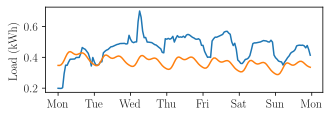

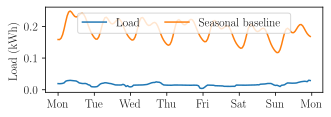

In [10]:
# Plot load and seasonal baseline for first week of January 2022
latexify(fig_width=5, fig_height=5*golden_mean/2)
fig, ax = plt.subplots()
week_load_data = test.loc['2022-01-03':'2022-01-09']
week_baseline_data = test_baseline_series.loc['2022-01-03':'2022-01-09']
plt.plot(week_load_data.index, week_load_data.values, color="tab:blue")
plt.plot(week_baseline_data.index, week_baseline_data.values, color="tab:orange")
plt.ylabel("Load (kWh)")
customize_weekly_x_axis(ax, week_load_data.index[0])

# plt.savefig("figures/baseline_jan.pdf")

# Plot load and seasonal baseline for first week of July 2022
latexify(fig_width=5, fig_height=5*golden_mean/2)
fig, ax = plt.subplots()
week_load_data = test.loc['2022-07-04':'2022-07-10']
week_baseline_data = test_baseline_series.loc['2022-07-04':'2022-07-10']
plt.plot(week_load_data.index, week_load_data.values, color="tab:blue", label="Load")
plt.plot(week_baseline_data.index, week_baseline_data.values, color="tab:orange", label="Seasonal baseline")
plt.ylabel("Load (kWh)")
customize_weekly_x_axis(ax, week_load_data.index[0])
plt.legend(loc='upper center', ncol=2)

# plt.savefig("figures/baseline_jul.pdf")


